# Microglia Metabolism Data Analysis

In [2]:
import numpy as np # allows for efficient calculations and manipulation with arrays
import pandas as pd # allows for the use of data frames and application of data science
import matplotlib.pyplot as plt # used for object-oriented plotting or general plotting
from matplotlib.lines import Line2D # allows to manually change the objects that appear in the legend
import seaborn as sns # allows for visualizations
import regex as re # for manipulating strings
import polars as pl # to handle a large dataset
import scipy.optimize as scpy # allows for plotting of logistic curves

# modules to support in non-linear fitting
import statsmodels.api as sm
from ISLP.models import (summarize,
    poly,
    ModelSpec as MS)
from statsmodels.stats.anova import anova_lm


sns.set_style('darkgrid')
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Glucose Uptake Graph

In [4]:
# reading in glucose data using polars for efficiency
glucose_df = pl.read_csv("glucose_uptake_data/glucose_uptake_measure (1).csv")

In [5]:
# dataframe view
glucose_df.head()

[run number],init-plaque,init-microglia,fortify-probability,eat-probability,lactate-probability,added-glucose,init-pH,init-vessels,metabolic_booster?,[step],total_perm,global-glucose
i64,i64,i64,f64,f64,f64,i64,f64,i64,bool,i64,f64,i64
7,5,10,0.1,0.1,0.2,2400,7.1,5,false,0,113.879091,2400
8,5,10,0.1,0.1,0.2,2400,7.1,5,false,0,110.434591,2400
3,5,10,0.1,0.1,0.2,2400,7.1,5,false,0,103.861118,2400
5,5,10,0.1,0.1,0.2,2400,7.1,5,false,0,115.624041,2400
1,5,10,0.1,0.1,0.2,2400,7.1,5,false,0,106.669185,2400


In [6]:
# list to store the relavent amount of ticks
big_tick_num_list = np.arange(0,38523)
big_tick_num_list

array([    0,     1,     2, ..., 38520, 38521, 38522])

In [7]:
# modeling a specific instance of glucose/hour
(glucose_df.filter(glucose_df['[step]'] == 21)['global-glucose']/21).mean()

1639.6457142857141

In [8]:
# global_glucose values over hour(tick) by average (~30 sec to run)

global_glucose_by_hour_mean_vals = [(glucose_df.filter(glucose_df['[step]'] == tick_num)['global-glucose']/tick_num).mean()
           for tick_num in big_tick_num_list]

total_perm_mean = [glucose_df.filter(glucose_df['[step]'] == tick_num)['total_perm'].mean()
           for tick_num in big_tick_num_list]

In [9]:
# working pandas dataframe for analysis
glucose_perm_df = pd.DataFrame(
                          {'tick':big_tick_num_list,
                          "global_glucose_vals":global_glucose_by_hour_mean_vals,
                          "total_perm_mean":total_perm_mean})


In [10]:
# impute the misisng value due to 0/0
glucose_perm_df.iloc[0,1] = 2400

In [11]:
# dataframe view
glucose_perm_df.head()

,tick,global_glucose_vals,total_perm_mean
0,0,2400.00,113.675879
1,1,4480.80,113.676679
2,2,3255.60,113.679479
3,3,2720.08,113.682279
4,4,2440.98,113.687079


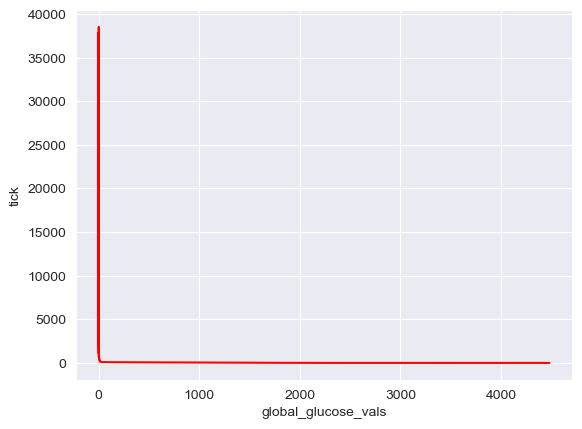

In [12]:
# plotting of global glucose by hour
sns.lineplot(glucose_perm_df,y='tick',x='global_glucose_vals',color='r');

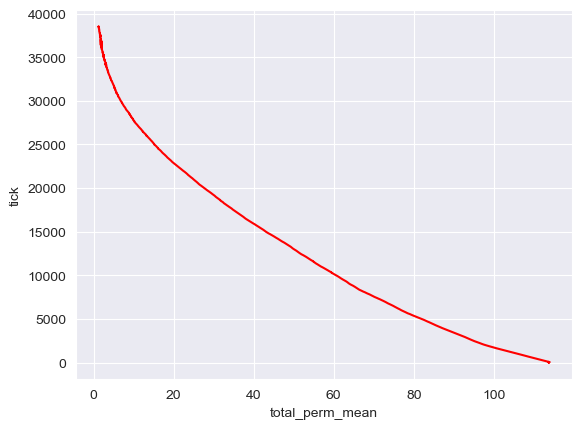

In [13]:
# plot of the total_perm over the ticks in the data
sns.lineplot(glucose_perm_df,y='tick',x='total_perm_mean',color='r');

## Met. Booster (T/F) Graphs

In [15]:
# reading in met booster data
met_booster_false = pd.read_csv("met_booster_data/met_booster_run(false).csv")
met_booster_true = pd.read_csv("met_booster_data/met_booster_run(true).csv")

In [16]:
# examine data types
met_booster_false.dtypes

[run number]                        int64
init-plaque                         int64
init-microglia                      int64
fortify-probability               float64
eat-probability                   float64
lactate-probability               float64
added-glucose                       int64
init-pH                           float64
init-vessels                        int64
metabolic_booster?                   bool
[step]                              int64
mean [permeability] of patches    float64
dtype: object

In [17]:
# number of simulations(1 simulation = 1 year)
sim_num_list = np.arange(0,26)

In [18]:
# list of the ticks
tick_num_list = np.arange(0,8761)

In [19]:
# list of ticks represenented as day value
day_vals = [i/24 for i in tick_num_list]

In [20]:

# filter the original data frame each run then calculate the mean perm for that run
mean_for_sims_ticks_true = [met_booster_true.loc[met_booster_true['[step]'] == tick_num]["mean [permeability] of patches"].mean()
                     for tick_num in tick_num_list]



mean_for_sims_ticks_false = [met_booster_false.loc[met_booster_false['[step]'] == tick_num]["mean [permeability] of patches"].mean()
                     for tick_num in tick_num_list]





In [21]:
# working dataframe for data analysis for the met booster data
mean_perm_df = pd.DataFrame(
                          {'tick':tick_num_list,
                           'day':day_vals,
                          "mean_for_perm_booster_true":mean_for_sims_ticks_true,
                          "mean_for_perm_booster_false":mean_for_sims_ticks_false})



In [22]:
mean_perm_df.head()

,tick,day,mean_for_perm_booster_true,mean_for_perm_booster_false
0,0,0.000000,0.093727,0.100252
1,1,0.041667,0.093727,0.100252
2,2,0.083333,0.093729,0.100253
3,3,0.125000,0.093732,0.100255
4,4,0.166667,0.093735,0.100259


In [23]:
# scope of time values in the data
quarter = 8670/4
quarter_in_days = int(round((quarter ) / (24),0))

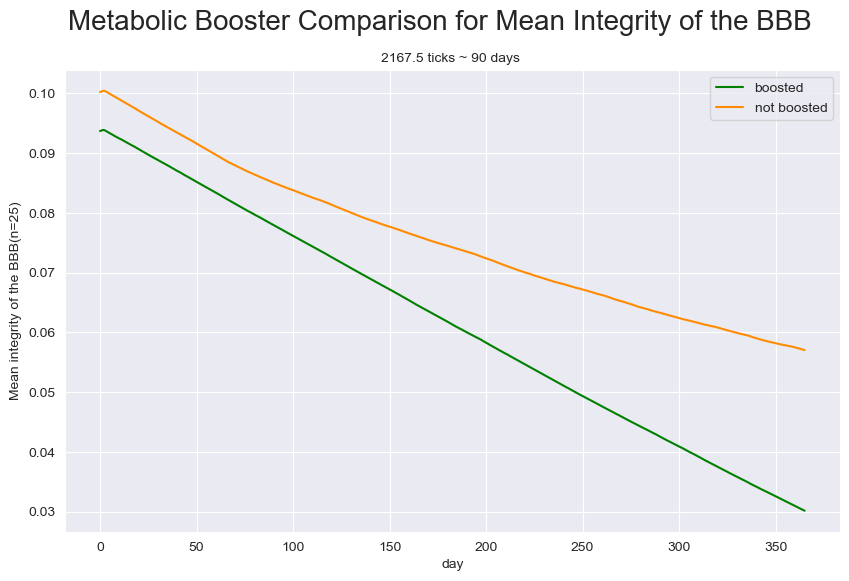

In [24]:
# plotting of met booster data
plt.figure(figsize=(10,6))

sns.lineplot(mean_perm_df,x='day',y='mean_for_perm_booster_true',label='boosted',color='g')
sns.lineplot(mean_perm_df,x='day',y='mean_for_perm_booster_false',label='not boosted',color='darkorange')


plt.ylabel('Mean integrity of the BBB(n=25)')
plt.suptitle("Metabolic Booster Comparison for Mean Integrity of the BBB",fontsize=20)
plt.title(f"{quarter} ticks ~ {quarter_in_days} days ",fontsize=10)
plt.show()



## Measure of pH and Aβ in 365 days

In [26]:
# reading pH data
pH_met_booster_false = pd.read_csv("ph_measure_data/ph_measure_met_booster(false).csv")
pH_met_booster_true = pd.read_csv("ph_measure_data/ph_measure_met_booster(true).csv")
# reading plaque data
ab_met_booster_false = pd.read_csv("ab_measure_data/ab_measure_met_booster(false).csv")
ab_met_booster_true = pd.read_csv("ab_measure_data/ab_measure_met_booster(true).csv")

In [27]:

# filter the original data frame for each tick to obatin its respective mean pH value
mean_for_sims_ticks_ph_true = [pH_met_booster_true.loc[pH_met_booster_true['[step]'] == tick_num]["global-pH"].mean()
                     for tick_num in tick_num_list]



mean_for_sims_ticks_ph_false = [pH_met_booster_false.loc[pH_met_booster_false['[step]'] == tick_num]["global-pH"].mean()
                     for tick_num in tick_num_list]





In [28]:

# filter the original data frame for each tick to obatin its respective plaque_percent value
ab_tick_met_booster_true = [ab_met_booster_true.loc[ab_met_booster_true['[step]'] == tick_num]["plaque_percent"].mean()
                     for tick_num in tick_num_list]



ab_tick_met_booster_false = [ab_met_booster_false.loc[ab_met_booster_false['[step]'] == tick_num]["plaque_percent"].mean()
                     for tick_num in tick_num_list]



In [29]:
# working dataframe for data analysis for the pH data
ph_df = pd.DataFrame(
                          {'tick':tick_num_list,
                           'day':day_vals,
                          "ph_sim_true":mean_for_sims_ticks_ph_true,
                          "ph_sim_false":mean_for_sims_ticks_ph_false})

In [30]:
# working dataframe for data analysis for the plaque data

plaque_percent_df = pd.DataFrame(
                          {'tick':tick_num_list,
                           'day':day_vals,
                          "ab_percent_sim_true":ab_tick_met_booster_true,
                          "ab_percent_sim_false":ab_tick_met_booster_false})

In [31]:
# calculating line of best fit data for not boosted values
ph_m_booster_false, ph_b_booster_false = np.polyfit(ph_df['day'],ph_df['ph_sim_false'],1)

ph_df['best_fit_booster_false'] = ph_m_booster_false * ph_df['day'] + ph_b_booster_false


In [32]:
# calculating line of best fit data for boosted values
ph_m_booster_true, ph_b_booster_true = np.polyfit(ph_df['day'],ph_df['ph_sim_true'],1)

ph_df['best_fit_booster_true'] = ph_m_booster_true * ph_df['day'] + ph_b_booster_false


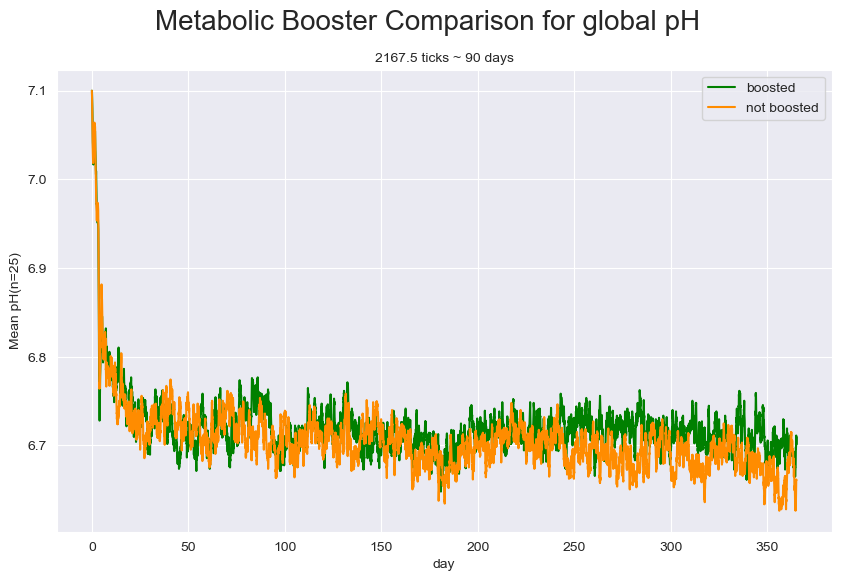

In [33]:
# plotting of ph met booster data
plt.figure(figsize=(10,6))

sns.lineplot(ph_df,x='day',y='ph_sim_true',label='boosted',color='g')
sns.lineplot(ph_df,x='day',y='ph_sim_false',label='not boosted',color='darkorange')


plt.ylabel('Mean pH(n=25)')
plt.suptitle("Metabolic Booster Comparison for global pH ",fontsize=20)
plt.title(f"{quarter} ticks ~ {quarter_in_days} days",fontsize=10)
plt.show()



In [34]:
# variables holding the equations of line of best fit for the pH data
ph_false_eqaution = f'Equation(not boosted): {round(ph_m_booster_false,7)}x + {round(ph_b_booster_false,2)}'
ph_true_eqaution = f'Equation(boosted): {round(ph_m_booster_true,7)}x + {round(ph_b_booster_true,2)}'
print(ph_true_eqaution),print(ph_false_eqaution);

Equation(boosted): -0.0001276x + 6.74
Equation(not boosted): -0.0002219x + 6.75


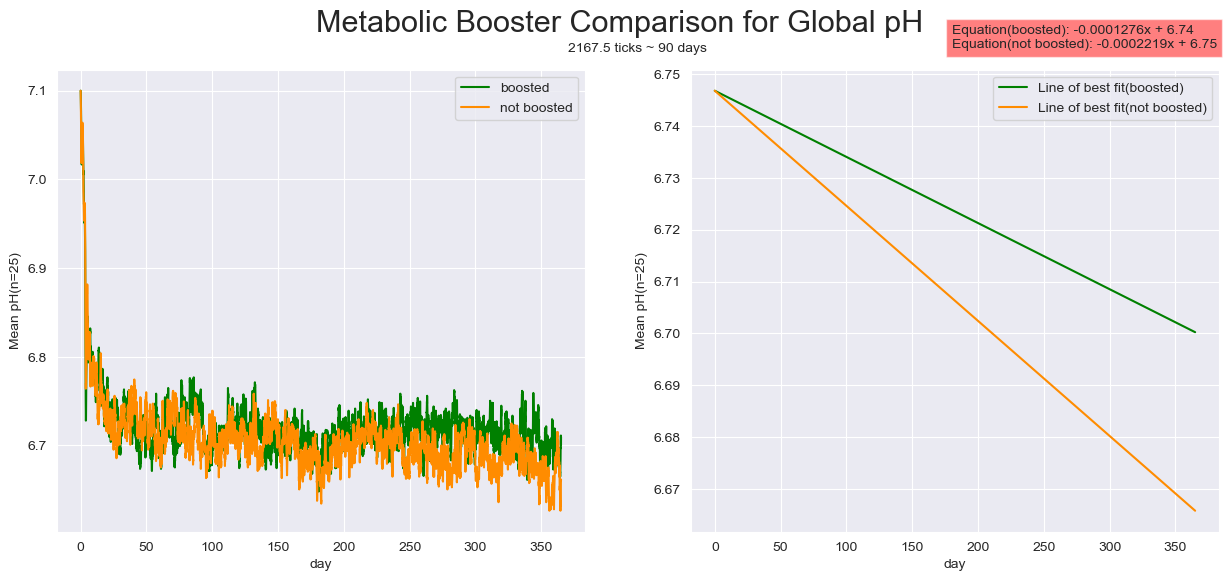

In [35]:
# plotting of ph met booster data
fig,ax = plt.subplots(1,2,figsize=(15,6))

sns.lineplot(ph_df,x='day',y='ph_sim_true',label='boosted',color='g',ax=ax[0])
sns.lineplot(ph_df,x='day',y='ph_sim_false',label='not boosted',color='darkorange',ax=ax[0])

# put the apporiate y-label
ax[0].set_ylabel('Mean pH(n=25)')
# plotting of line of best fit

sns.lineplot(ph_df,x='day',y='best_fit_booster_true',label='Line of best fit(boosted)',color='g',ax=ax[1])
sns.lineplot(ph_df,x='day',y='best_fit_booster_false',label='Line of best fit(not boosted)',color='darkorange',ax=ax[1])


# plotting logistics
plt.ylabel('Mean pH(n=25)')
plt.suptitle("Metabolic Booster Comparison for Global pH",fontsize=22)
                                                            # adjust the sub title position
plt.title(f"{quarter} ticks ~ {quarter_in_days} days",fontsize=10,x=-.1,y=1.02)



# plot the equations of the line of best fits

plt.text(180,6.755,ph_true_eqaution+"\n"+ ph_false_eqaution,bbox=dict(facecolor='red', alpha=0.5),ha='left',fontsize=10)

plt.show()

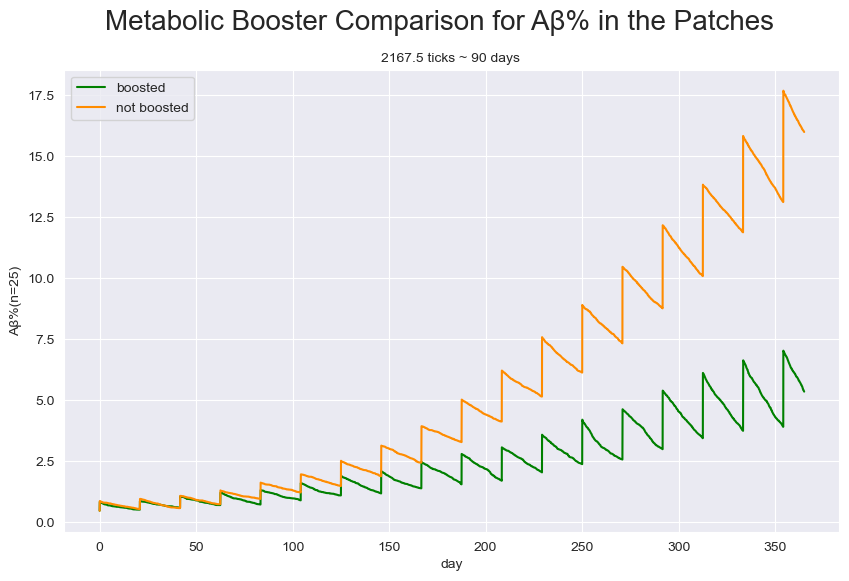

In [36]:
# plotting of ab_percent met booster data
plt.figure(figsize=(10,6))

sns.lineplot(plaque_percent_df,x='day',y='ab_percent_sim_true',label='boosted',color='g')
sns.lineplot(plaque_percent_df,x='day',y='ab_percent_sim_false',label='not boosted',color='darkorange')


plt.ylabel('Aβ%(n=25)')
plt.suptitle("Metabolic Booster Comparison for Aβ% in the Patches",fontsize=20)
plt.title(f"{quarter} ticks ~ {quarter_in_days} days ",fontsize=10)
plt.show()



In [37]:
# calculating line of best fit data for not boosted values
m_booster_false, b_booster_false = np.polyfit(plaque_percent_df['day'],plaque_percent_df['ab_percent_sim_false'],1)

plaque_percent_df['best_fit_booster_false'] = m_booster_false * plaque_percent_df['day'] + b_booster_false


In [38]:
# calculating line of best fit data for boosted values
m_booster_true, b_booster_true = np.polyfit(plaque_percent_df['day'],plaque_percent_df['ab_percent_sim_true'],1)

plaque_percent_df['best_fit_booster_true'] = m_booster_true * plaque_percent_df['day'] + b_booster_true


In [39]:
# variables holding the equations of line of best fit for the plaque data
ab_false_eqaution = f'Equation(not boosted): {round(m_booster_false,7)}x + {round(b_booster_false,2)}'
ab_true_eqaution = f'Equation(boosted): {round(m_booster_true,7)}x + {round(b_booster_true,2)}'
print(ab_true_eqaution),print(ab_false_eqaution);

Equation(boosted): 0.0141467x + -0.13
Equation(not boosted): 0.042743x + -2.28


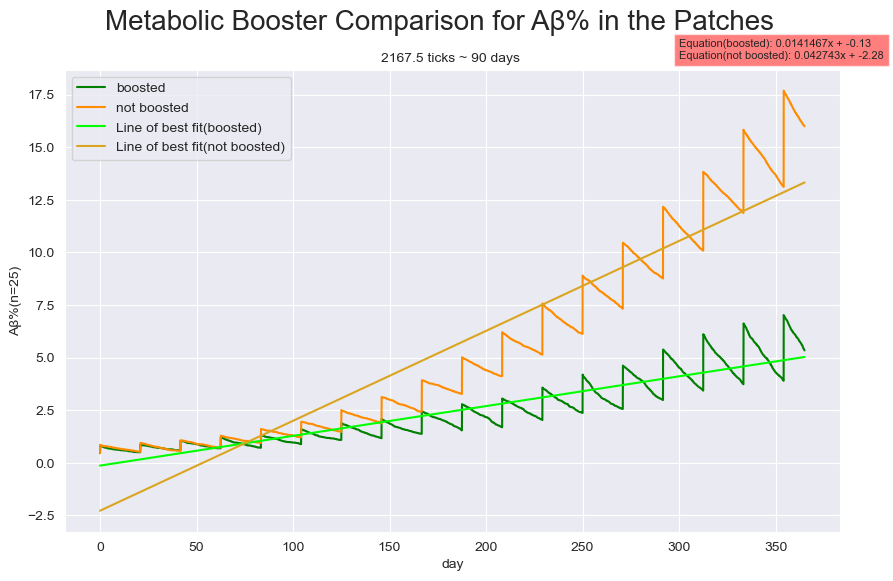

In [40]:
# plotting of ab_percent met booster data
plt.figure(figsize=(10,6))

sns.lineplot(plaque_percent_df,x='day',y='ab_percent_sim_true',label='boosted',color='g')
sns.lineplot(plaque_percent_df,x='day',y='ab_percent_sim_false',label='not boosted',color='darkorange')

# plotting line of best fit data

sns.lineplot(plaque_percent_df,x='day',y='best_fit_booster_true',label='Line of best fit(boosted)',color='lime')
sns.lineplot(plaque_percent_df,x='day',y='best_fit_booster_false',label='Line of best fit(not boosted)',color='goldenrod')


# plot the eqautions of the line of best fits

plt.text(300,19.2,ab_true_eqaution+"\n"+ ab_false_eqaution,bbox=dict(facecolor='red', alpha=0.5),ha='left',fontsize=8)



plt.ylabel('Aβ%(n=25)')
plt.suptitle("Metabolic Booster Comparison for Aβ% in the Patches",fontsize=20)
plt.title(f"{quarter} ticks ~ {quarter_in_days} days ",fontsize=10)
plt.show()



## Updated Graphs
 - Metabolic Booster Comparison for Aβ% in the Patches with fitting of Logistic Curves
 - Astrocyte and/or with Microglia graphs

### Logistic Fitting

In [43]:
# Define the logistic function
def logistic(x, L, k, x0):
    """
    series, float, float, float -> series

    Expects the time series values, the maximum value, the growth rate, and the midpoint
    returns a series of values that correspond the growth of the Aβ plaques

    """
     # return the value of the logistic fucntion
    return L / (1 + np.exp(-k * (x - x0)))





In [44]:
# storing relevant data

# time frame
x = plaque_percent_df.day


# values of the percent of presence of Aβ with Met_booster=True
y_true = plaque_percent_df.ab_percent_sim_true
# max value of the percent of plaques when Met_booster=True,m using this value as the L estimate
y_max_true = plaque_percent_df.ab_percent_sim_true.max()


# values of the percent of presence of Aβ with Met_booster=False
y_false = plaque_percent_df.ab_percent_sim_false
# max value of the percent of plaques when Met_booster=False,m using this value as the L estimate
y_max_false = plaque_percent_df.ab_percent_sim_false.max()

# value of the estimate of the mid point for each class

x_mid_true = y_max_true/2
x_mid_false = y_max_false/2




In [45]:


# obtain the optimal values for L,k, and x0 for both classes of the the metabolic booster with `curve_fit` method

L_true,k_true,x0_true = scpy.curve_fit(logistic,x,y_true,
                                  # entering estimates for  L,k, and x0
                                  # k = 1 because it provides an initial value for controlling the steepness of the curve
                                  p0=[y_max_true,1,x_mid_true])[0]


L_false,k_false,x0_false = scpy.curve_fit(logistic,x,y_false,p0=[y_max_false,1,x_mid_false])[0]




In [46]:
# fit the estimated values for L,k, and x0 for both classes of the metabolic booster

y_true_fitted = logistic(x,L_true,k_true,x0_true)
y_false_fitted = logistic(x,L_false,k_false,x0_false)



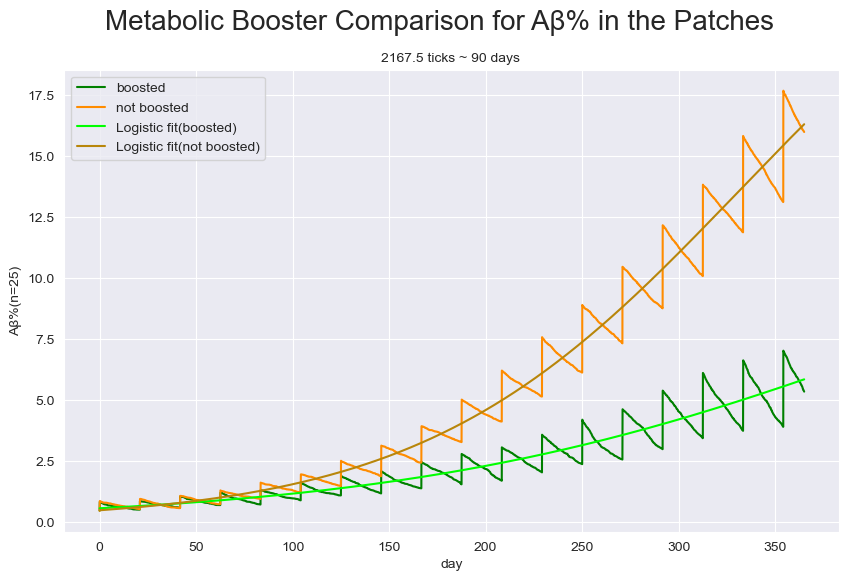

In [47]:
# plot the logistcic curves over the data


plt.figure(figsize=(10,6))

sns.lineplot(plaque_percent_df,x='day',y='ab_percent_sim_true',label='boosted',color='g')
sns.lineplot(plaque_percent_df,x='day',y='ab_percent_sim_false',label='not boosted',color='darkorange')

# plotting the curves

sns.lineplot(plaque_percent_df,x='day',y=y_true_fitted,label='Logistic fit(boosted)',color='lime')
sns.lineplot(plaque_percent_df,x='day',y=y_false_fitted,label='Logistic fit(not boosted)',color='darkgoldenrod')



plt.ylabel('Aβ%(n=25)')
plt.suptitle("Metabolic Booster Comparison for Aβ% in the Patches",fontsize=20)
plt.title(f"{quarter} ticks ~ {quarter_in_days} days ",fontsize=10)
plt.show()





## Analyzing the Treatments

**No treatment:** exercise is set to none and the metabolic booster is set to none

**Moderate treatment:** exercise  is set to moderate and metabolic booster is set to twice per week

**High treatment:** exercise is set to high and metabolic booster is set to daily

In [49]:
# loading the data for each treatment

treatment_none = pd.read_csv("treatment_data/treatment_none.csv")
treatment_moderate = pd.read_csv("treatment_data/treatment_moderate.csv")
treatment_high = pd.read_csv("treatment_data/treatment_high.csv")

#### Processing



In [51]:
# obtaing the mean of each variable at each tick for all treatments
mean_ph_treatment_none = [treatment_none.loc[treatment_none["[step]"] == tick_num]["global-pH"].mean()  for tick_num in tick_num_list]
mean_plaque_percent_none = [treatment_none.loc[treatment_none["[step]"] == tick_num]["Aβ %"].mean()  for tick_num in tick_num_list]
mean_integrity_none = [treatment_none.loc[treatment_none["[step]"] == tick_num]["global-integrity"].mean()  for tick_num in tick_num_list]

mean_ph_treatment_moderate = [treatment_moderate.loc[treatment_moderate["[step]"] == tick_num]["global-pH"].mean()  for tick_num in tick_num_list]
mean_plaque_percent_moderate = [treatment_moderate.loc[treatment_moderate["[step]"] == tick_num]["Aβ %"].mean()  for tick_num in tick_num_list]
mean_integrity_moderate = [treatment_moderate.loc[treatment_moderate["[step]"] == tick_num]["global-integrity"].mean()  for tick_num in tick_num_list]

mean_ph_treatment_high = [treatment_high.loc[treatment_high["[step]"] == tick_num]["global-pH"].mean()  for tick_num in tick_num_list]
mean_plaque_percent_high = [treatment_high.loc[treatment_high["[step]"] == tick_num]["Aβ %"].mean()  for tick_num in tick_num_list]
mean_integrity_high = [treatment_high.loc[treatment_high["[step]"] == tick_num]["global-integrity"].mean()  for tick_num in tick_num_list]


In [52]:
# create dataframes that hold the means respective to the day and variables

treatment_means = pd.DataFrame({
    'tick':tick_num_list,
     'day':day_vals,
     "mean_ph_none": mean_ph_treatment_none,
    "mean_plaque_percent_none": mean_plaque_percent_none,
    "mean_integrity_none": mean_integrity_none,

    "mean_ph_moderate": mean_ph_treatment_moderate,
    "mean_plaque_percent_moderate": mean_plaque_percent_moderate,
    "mean_integrity_moderate": mean_integrity_moderate,

    "mean_ph_high": mean_ph_treatment_high,
    "mean_plaque_percent_high": mean_plaque_percent_high,
    "mean_integrity_high": mean_integrity_high
})

In [53]:
# working dataframe
treatment_means.head()

,tick,day,mean_ph_none,mean_plaque_percent_none,mean_integrity_none,mean_ph_moderate,mean_plaque_percent_moderate,mean_integrity_moderate,mean_ph_high,mean_plaque_percent_high,mean_integrity_high
0,0,0.000000,7.3000,0.002755,75.131513,7.3000,0.002755,74.873571,7.3000,0.002755,75.037260
1,1,0.041667,7.2984,0.012562,75.131513,7.3000,0.012415,75.862323,7.2992,0.011607,76.028683
2,2,0.083333,7.2960,0.012562,75.132523,7.2968,0.012342,75.863632,7.2944,0.011534,76.029473
3,3,0.125000,7.2896,0.012562,75.133074,7.2944,0.012342,75.864964,7.2912,0.011387,76.030185
4,4,0.166667,7.2856,0.012525,75.135279,7.2904,0.012342,75.867365,7.2824,0.011276,76.032673


### Group Comparison of Each Treatment 

- BBB integrity over time with 3 lines for each treatment

- AB plaque value % over time with 3 lines for each treatment

- Global pH over time with 3 lines for each treatment

In [55]:
# List of custom colors to have consistent colors
colors = ['grey', 'green', 'darkorange']  

# Create a seaborn color palette from the list. This will allow for consistent colors in the plots
sns.set_palette(colors)

In [56]:
# list of the treatment variable fields
treatment_vars = treatment_means.columns[2:]

In [57]:
# obatin lists that contain the feature names for each variable under each treatment
# this will help for efficient plotting of the graphs


vars_ph = [re.search(".*ph.*",field).group() for field in treatment_vars if re.search(".*ph.*",field) != None]
vars_plaque = [re.search(".*plaque.*",field).group() for field in treatment_vars if re.search(".*plaque.*",field) != None]
vars_integrity = [re.search(".*integrity.*",field).group() for field in treatment_vars if re.search(".*integrity.*",field) != None]

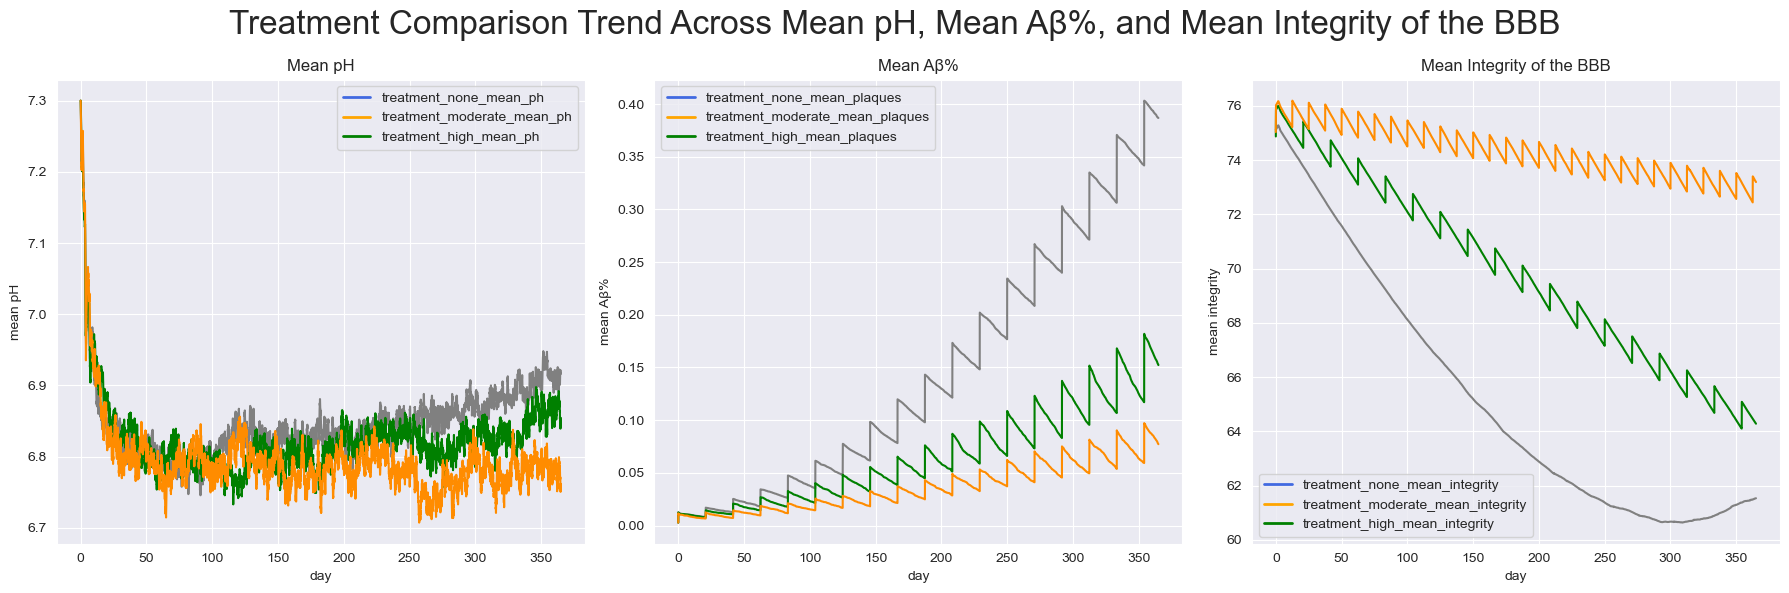

In [58]:
# establish subplots
fig, ax = plt.subplots(1,3,figsize=(18,6))


# plotting the ph data for each treatment
ph_plots = [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[0]) for var in vars_ph]
# plotting the plaque data for each treatment
plaque_plots =  [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[1]) for var in vars_plaque]
# plotting the integrity data for each treatment
integrity_plots = [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[2]) for var in vars_integrity]


# main title
plt.suptitle("Treatment Comparison Trend Across Mean pH, Mean Aβ%, and Mean Integrity of the BBB",size=24)

# setting appropriate titles for the subplots
[ph_plots[i].set_title("Mean pH") for i in np.arange(3)]
[plaque_plots[i].set_title("Mean Aβ%") for i in np.arange(3)]
[integrity_plots[i].set_title("Mean Integrity of the BBB") for i in np.arange(3)]
# setting appropriate y labels
[ph_plots[i].set_ylabel("mean pH") for i in np.arange(3)]
[plaque_plots[i].set_ylabel("mean Aβ%") for i in np.arange(3)]
[integrity_plots[i].set_ylabel("mean integrity") for i in np.arange(3)]

# setting appropriate legend lables

# creating custom handels(i.e. lines) that will be mapped on the legend 
custom_line_none_mean_ph = Line2D([],[],color='royalblue', linewidth=2, linestyle='-')
custom_line_moderate_mean_ph = Line2D([],[],color='orange', linewidth=2, linestyle='-')
custom_line_high_mean_ph = Line2D([],[],color='green', linewidth=2, linestyle='-')

# labels that will represent the custom handels
lables_ph = ["treatment_none_mean_ph","treatment_moderate_mean_ph","treatment_high_mean_ph"]
# plots the legend
[ph_plots[i].legend(handles = [custom_line_none_mean_ph,custom_line_moderate_mean_ph,custom_line_high_mean_ph],labels=lables_ph) 
 for i in np.arange(3)]

custom_line_none_mean_plaque = Line2D([],[],color='royalblue', linewidth=2, linestyle='-')
custom_line_moderate_mean_plaque = Line2D([],[],color='orange', linewidth=2, linestyle='-')
custom_line_high_mean_plaque = Line2D([],[],color='green', linewidth=2, linestyle='-')

lables_plaques = ["treatment_none_mean_plaques","treatment_moderate_mean_plaques","treatment_high_mean_plaques"]
[plaque_plots[i].legend(handles = [custom_line_none_mean_plaque,custom_line_moderate_mean_plaque,custom_line_high_mean_plaque],labels=lables_plaques) 
 for i in np.arange(3)]

custom_line_none_mean_ph = Line2D([],[],color='royalblue', linewidth=2, linestyle='-')
custom_line_moderate_mean_ph = Line2D([],[],color='orange', linewidth=2, linestyle='-')
custom_line_high_mean_ph = Line2D([],[],color='green', linewidth=2, linestyle='-')
lables_integrity = ["treatment_none_mean_integrity","treatment_moderate_mean_integrity","treatment_high_mean_integrity"]
[integrity_plots[i].legend(handles = [custom_line_none_mean_ph,custom_line_moderate_mean_ph,custom_line_high_mean_ph],labels=lables_integrity) 
 for i in np.arange(3)]




plt.tight_layout()

### Fitting Logistic Curves on `Treatment Comparison Trend Across Mean pH, Mean Aβ%, and Mean Integrity of the BBB` Plot

In [60]:
# List of the features sorted by the variables(ph,plaques%, and intergrity) 
all_vars = vars_ph+vars_plaque+vars_integrity
all_vars

['mean_ph_none',
 'mean_ph_moderate',
 'mean_ph_high',
 'mean_plaque_percent_none',
 'mean_plaque_percent_moderate',
 'mean_plaque_percent_high',
 'mean_integrity_none',
 'mean_integrity_moderate',
 'mean_integrity_high']

In [61]:
# storing relevant data

# time frame 
time_frame = treatment_means.day

# store all the response variables and their observations

response_variables = [treatment_means[treatment_var] for treatment_var in all_vars]

# store all max values of the response variables

response_variables_maxes = [treatment_means[treatment_var].max() for treatment_var in all_vars]

# store all mid points

response_variables_mid_points = [response_variable_max/2 for response_variable_max in response_variables_maxes]




In [62]:
# obtain the coefficients for L,k, and x0 for the response variables

coefficients_for_vars = [scpy.curve_fit(logistic,time_frame,response_variable, p0=[max_val,1,mid_point],maxfev=10000)[0] for response_variable,max_val,mid_point in zip(response_variables,response_variables_maxes,response_variables_mid_points)]



In [63]:
# fit the coefficients in the logistic fucntion to obtain the estimates

fitted_values = [logistic(time_frame,coefficients_for_vars[i][0],coefficients_for_vars[i][1],coefficients_for_vars[i][2]) for i in np.arange(len(coefficients_for_vars))]


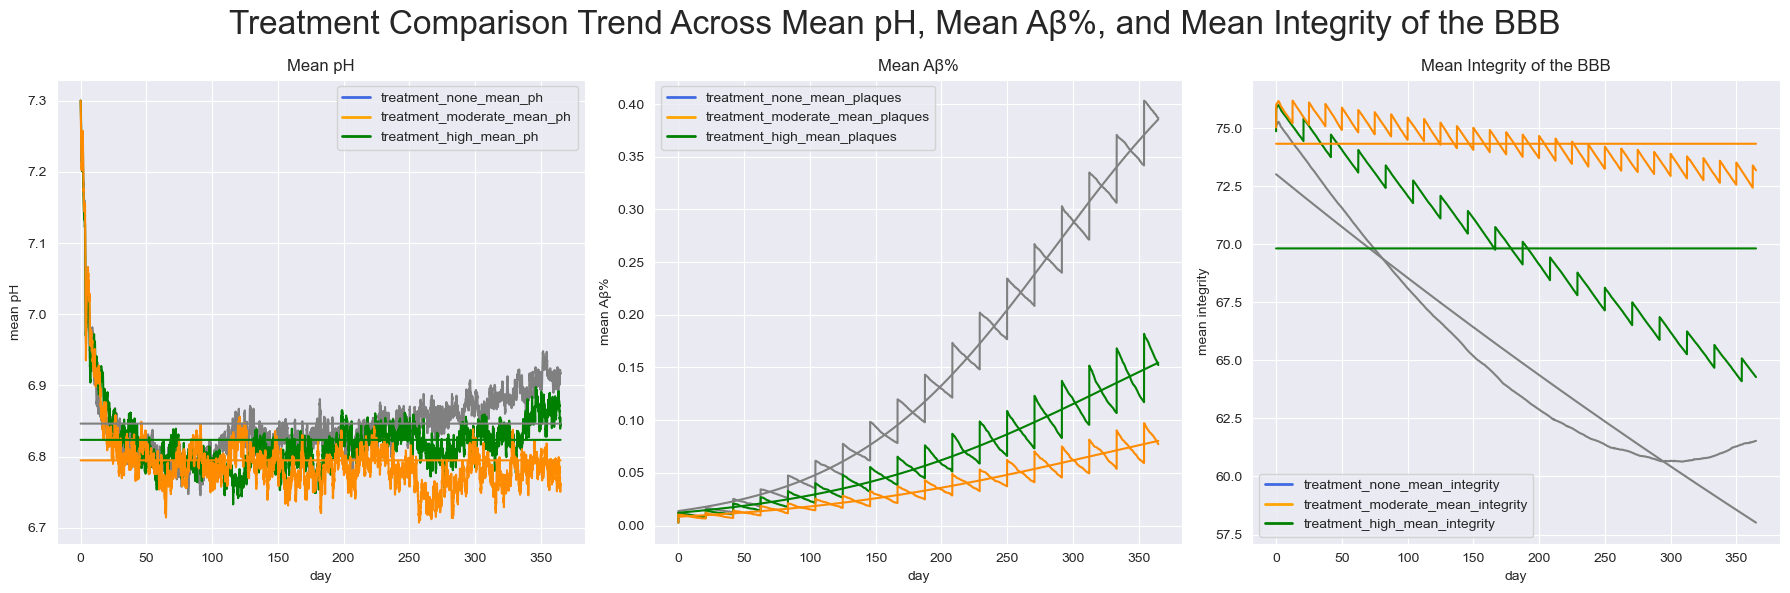

In [64]:
# establish the subplots 
fig, ax = plt.subplots(1,3,figsize=(18,6))


# treatment data plotting 
ph_plots = [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[0]) for var in vars_ph]
plaque_plots =  [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[1]) for var in vars_plaque]
integrity_plots = [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[2]) for var in vars_integrity]

# fitted treatment data plotting
fitted_ph_plots = [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[0]) for var in fitted_values[0:3]]
fitted_plaque_plots =  [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[1]) for var in fitted_values[3:6]]
fitted_integrity_plots = [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[2]) for var in fitted_values[6:9]]



# main title
plt.suptitle("Treatment Comparison Trend Across Mean pH, Mean Aβ%, and Mean Integrity of the BBB",size=24)

# setting appropriate titles for the subplots
[ph_plots[i].set_title("Mean pH") for i in np.arange(3)]
[plaque_plots[i].set_title("Mean Aβ%") for i in np.arange(3)]
[integrity_plots[i].set_title("Mean Integrity of the BBB") for i in np.arange(3)]
# setting appropriate y labels
[ph_plots[i].set_ylabel("mean pH") for i in np.arange(3)]
[plaque_plots[i].set_ylabel("mean Aβ%") for i in np.arange(3)]
[integrity_plots[i].set_ylabel("mean integrity") for i in np.arange(3)]

# setting appropriate legend lables

# creating custom handels(i.e. lines) that will be mapped on the legend 
custom_line_none_mean_ph = Line2D([],[],color='royalblue', linewidth=2, linestyle='-')
custom_line_moderate_mean_ph = Line2D([],[],color='orange', linewidth=2, linestyle='-')
custom_line_high_mean_ph = Line2D([],[],color='green', linewidth=2, linestyle='-')
lables_ph = ["treatment_none_mean_ph","treatment_moderate_mean_ph","treatment_high_mean_ph"]
[ph_plots[i].legend(handles = [custom_line_none_mean_ph,custom_line_moderate_mean_ph,custom_line_high_mean_ph],labels=lables_ph) 
 for i in np.arange(3)]

custom_line_none_mean_plaque = Line2D([],[],color='royalblue', linewidth=2, linestyle='-')
custom_line_moderate_mean_plaque = Line2D([],[],color='orange', linewidth=2, linestyle='-')
custom_line_high_mean_plaque = Line2D([],[],color='green', linewidth=2, linestyle='-')

lables_plaques = ["treatment_none_mean_plaques","treatment_moderate_mean_plaques","treatment_high_mean_plaques"]
[plaque_plots[i].legend(handles = [custom_line_none_mean_plaque,custom_line_moderate_mean_plaque,custom_line_high_mean_plaque],labels=lables_plaques) 
 for i in np.arange(3)]

custom_line_none_mean_integrity = Line2D([],[],color='royalblue', linewidth=2, linestyle='-')
custom_line_moderate_mean_integrity = Line2D([],[],color='orange', linewidth=2, linestyle='-')
custom_line_high_mean_integrity = Line2D([],[],color='green', linewidth=2, linestyle='-')
lables_integrity = ["treatment_none_mean_integrity","treatment_moderate_mean_integrity","treatment_high_mean_integrity"]
[integrity_plots[i].legend(handles = [custom_line_none_mean_integrity,custom_line_moderate_mean_integrity,custom_line_high_mean_integrity],labels=lables_integrity) 
 for i in np.arange(3)]




plt.tight_layout()




**Finding:**  
The logistic function used in earlier graphs did not suffice for the pH and integrity data, so I will perform polynomial regression to fit the trend lines for this data.

## Polynomial Regression
Fit lines to the non **Non-Linear Data:**

- All mean pH data for all treatmeants

- All mean Integrity data for all treatmeants

In [67]:

# store the response variables that are non-linear

non_linear_variables = vars_ph + vars_integrity

non_linear_variables


['mean_ph_none',
 'mean_ph_moderate',
 'mean_ph_high',
 'mean_integrity_none',
 'mean_integrity_moderate',
 'mean_integrity_high']

### Locate a Optimal Value for the Degree


In [69]:
def treatment_rss_plot(d,var):
    
    """
    int str -> plot & dataframe
    
    Will return the RSS trend for the ph variables for a given degree by default
    Or of the integrity variables for a given degree if var is specified diffrently
    """
    
    if var == 'ph': 
        
        
         # create a model for degrees 1-74
                        # ending the range at 75 beacause the design matrices greater 75 contain NaN's for their fit value
        dummy_poly_models = [MS([poly('day',degree=d)]) for d in np.arange(1,d)]

        # store the design matrix for each model
        design_mats = [model.fit_transform(treatment_means) for model in dummy_poly_models]

        # perform an analysis of variance on the design matrices. This will contain values for the RSS(residual sum of squares)


        vars_ph_anovas = [anova_lm(
        # *, is the `splat` operator, its fucntion here is to unpack each fitted model,
        # Genreally, it extracts each element in the list it is placed before
        *[sm.OLS(treatment_means[var_ph],design_mat).fit() for design_mat in design_mats]) for var_ph in vars_ph]

        # create a dataframe to format RSS values of each treatment
        
        rss_vals = pd.DataFrame({
            "degree":np.arange(1,d),
            "RSS_mean_ph_none":vars_ph_anovas[0].ssr,
            "RSS_mean_ph_moderate":vars_ph_anovas[1].ssr,
            "RSS_mean_ph_high":vars_ph_anovas[2].ssr
        })
 
    
        # vizualize the trend of RSS

        fig,ax = plt.subplots(1,3,figsize=(24,8))


        sns.lineplot(data=rss_vals,x='degree',y="RSS_mean_ph_none",ax=ax[0])
        sns.lineplot(data=rss_vals,x='degree',y="RSS_mean_ph_moderate",ax=ax[1])
        sns.lineplot(data=rss_vals,x='degree',y="RSS_mean_ph_high",ax=ax[2])

    
    
    
        plt.suptitle(f"RSS Trend for Polynomial Models taken from Degrees 1-{d-1}",size=20)
        plt.show()
        
        return rss_vals

    else:

         # create a model for degrees 1-74
                         # ending the range at 75 beacause the design matrices greater 75 contain NaN's for their fit value
        dummy_poly_models = [MS([poly('day',degree=d)]) for d in np.arange(1,d)]

        # store the design matrix for each model
        design_mats = [model.fit_transform(treatment_means) for model in dummy_poly_models]

        # perform an analysis of variance on the design matrices. This will contain values for the RSS(residual sum of squares)


        vars_integrity_anovas = [anova_lm(
        # *, is `splat` operator, its fucntion here is to unpack each fitted model,
        # Genreally, it extracts each element in the list it is placed before
        *[sm.OLS(treatment_means[var_integrity],design_mat).fit() for design_mat in design_mats])for var_integrity in vars_integrity] 

        # create a dataframe to format RSS values of each treatment
        
        rss_vals = pd.DataFrame({
            "degree":np.arange(1,d),
            "RSS_mean_integrity_none":vars_integrity_anovas[0].ssr,
            "RSS_mean_integrity_moderate":vars_integrity_anovas[1].ssr,
            "RSS_mean_integrity_high":vars_integrity_anovas[2].ssr
        })
    
 
    
        # vizualize the trend of RSS 

        fig,ax = plt.subplots(1,3,figsize=(24,8))


        sns.lineplot(data=rss_vals,x='degree',y="RSS_mean_integrity_none",ax=ax[0])
        sns.lineplot(data=rss_vals,x='degree',y="RSS_mean_integrity_moderate",ax=ax[1])
        sns.lineplot(data=rss_vals,x='degree',y="RSS_mean_integrity_high",ax=ax[2])

    
    
    
        plt.suptitle(f"RSS Trend for Polynomial Models taken from Degrees 1-{d-1}",size=20)
        plt.show()
        return rss_vals
    

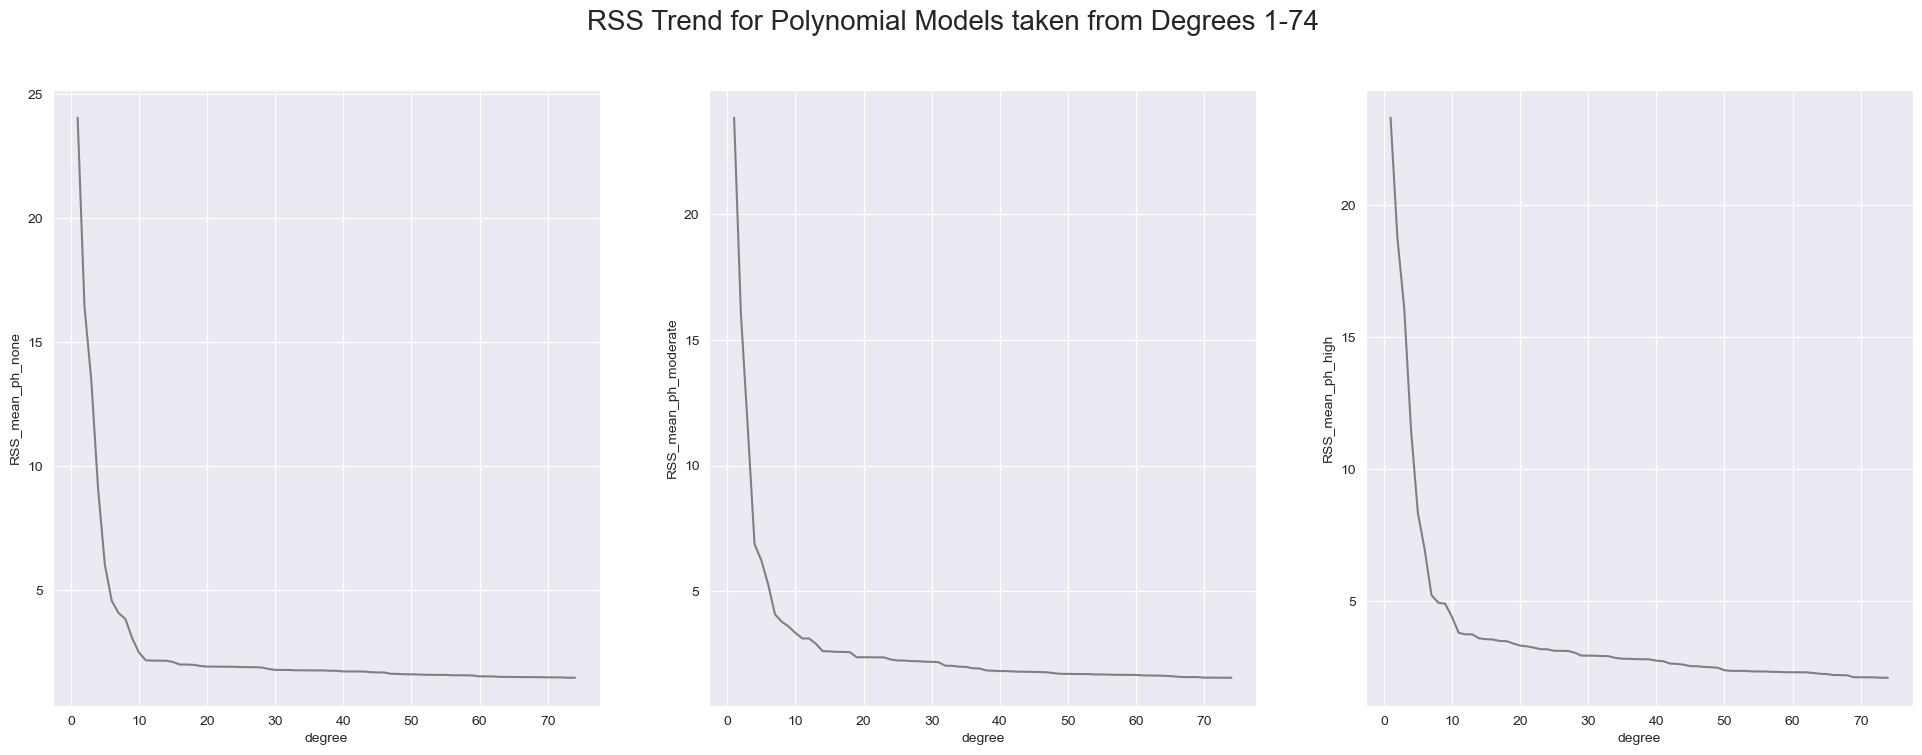

,degree,RSS_mean_ph_none,RSS_mean_ph_moderate,RSS_mean_ph_high
0,1,24.051874,23.825809,23.318924
1,2,16.446820,16.018050,18.766206
2,3,13.475942,11.529868,16.105316
3,4,9.083646,6.876759,11.498181
4,5,6.005051,6.228402,8.346359
...,...,...,...,...
69,70,1.469169,1.569340,2.108979
70,71,1.468245,1.568955,2.108739
71,72,1.467941,1.568247,2.105150
72,73,1.454448,1.565615,2.092577


In [70]:
treatment_rss_plot(75,'ph')

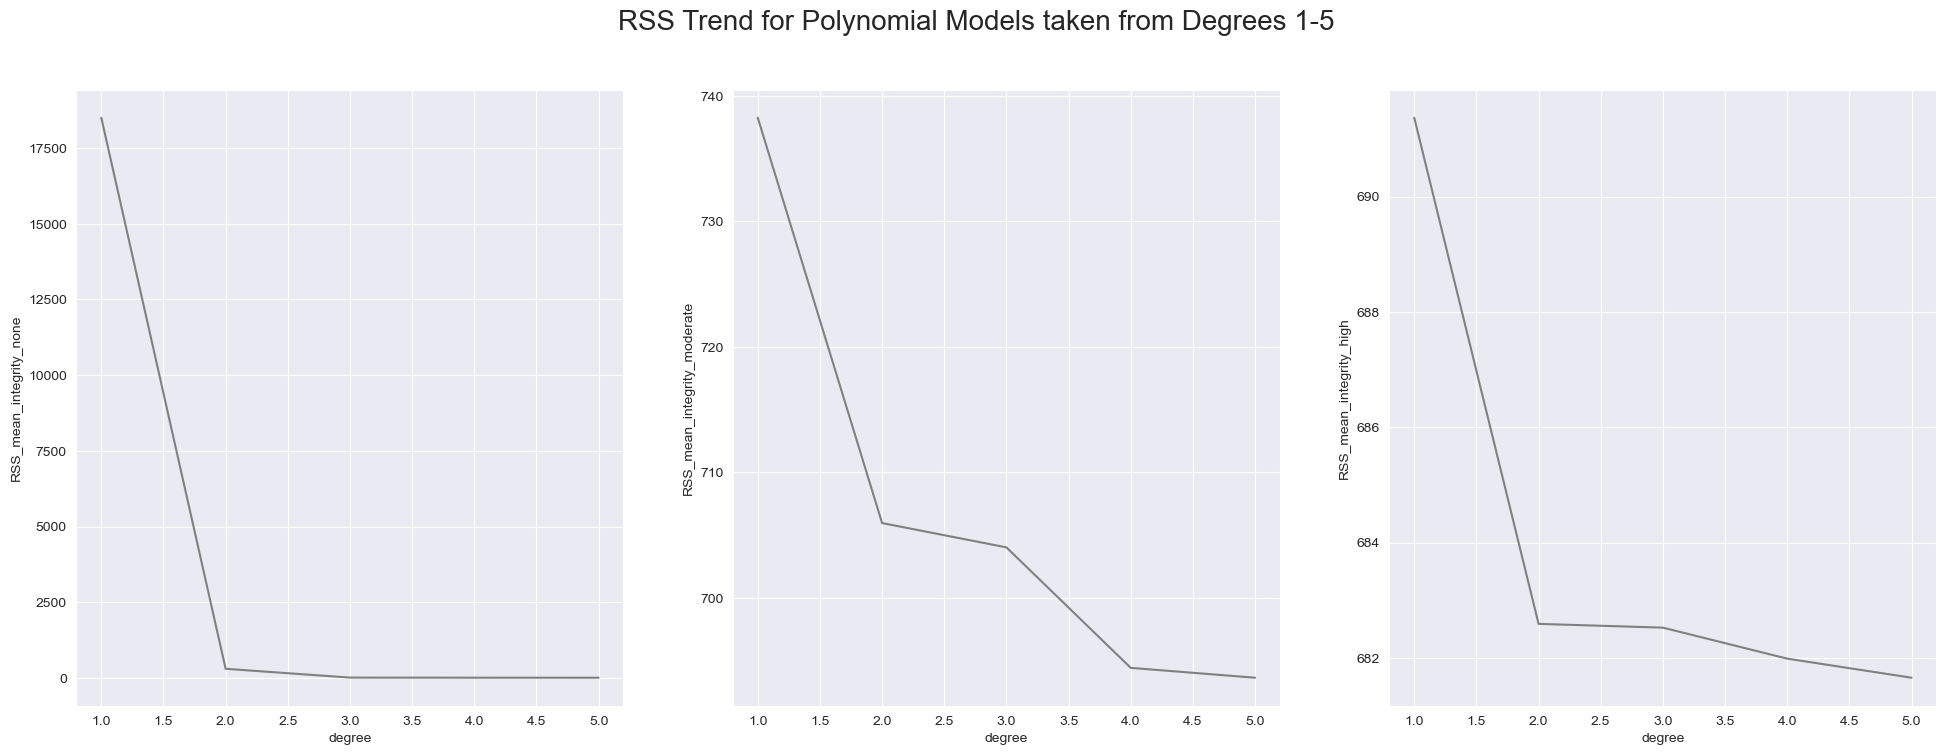

,degree,RSS_mean_integrity_none,RSS_mean_integrity_moderate,RSS_mean_integrity_high
0,1,18501.090089,738.255979,691.370298
1,2,305.162167,705.961965,682.589041
2,3,14.967486,704.023590,682.523589
3,4,11.988512,694.424197,681.985710
4,5,10.838312,693.639399,681.654871


In [71]:
treatment_rss_plot(6,'integrity')

**Finding:**  
From observing the plot, I will choose a degree 12 polynomial model for the pH data and a degrere 3 for the integrity data, as it appears that the RSS stops decreasing and begins to flatten. This is a better choice than the degree with the minimum RSS, as using a higher degree would overfit the model, leading to high variance in the fit and poor generalization to the data.

### Modeling Polynomial Fits

In [74]:
# creating a grid for the day values 

day_grid = np.linspace(treatment_means.day.min(),
                      treatment_means.day.max(),
                      365)

day_df = pd.DataFrame({'day':day_grid})

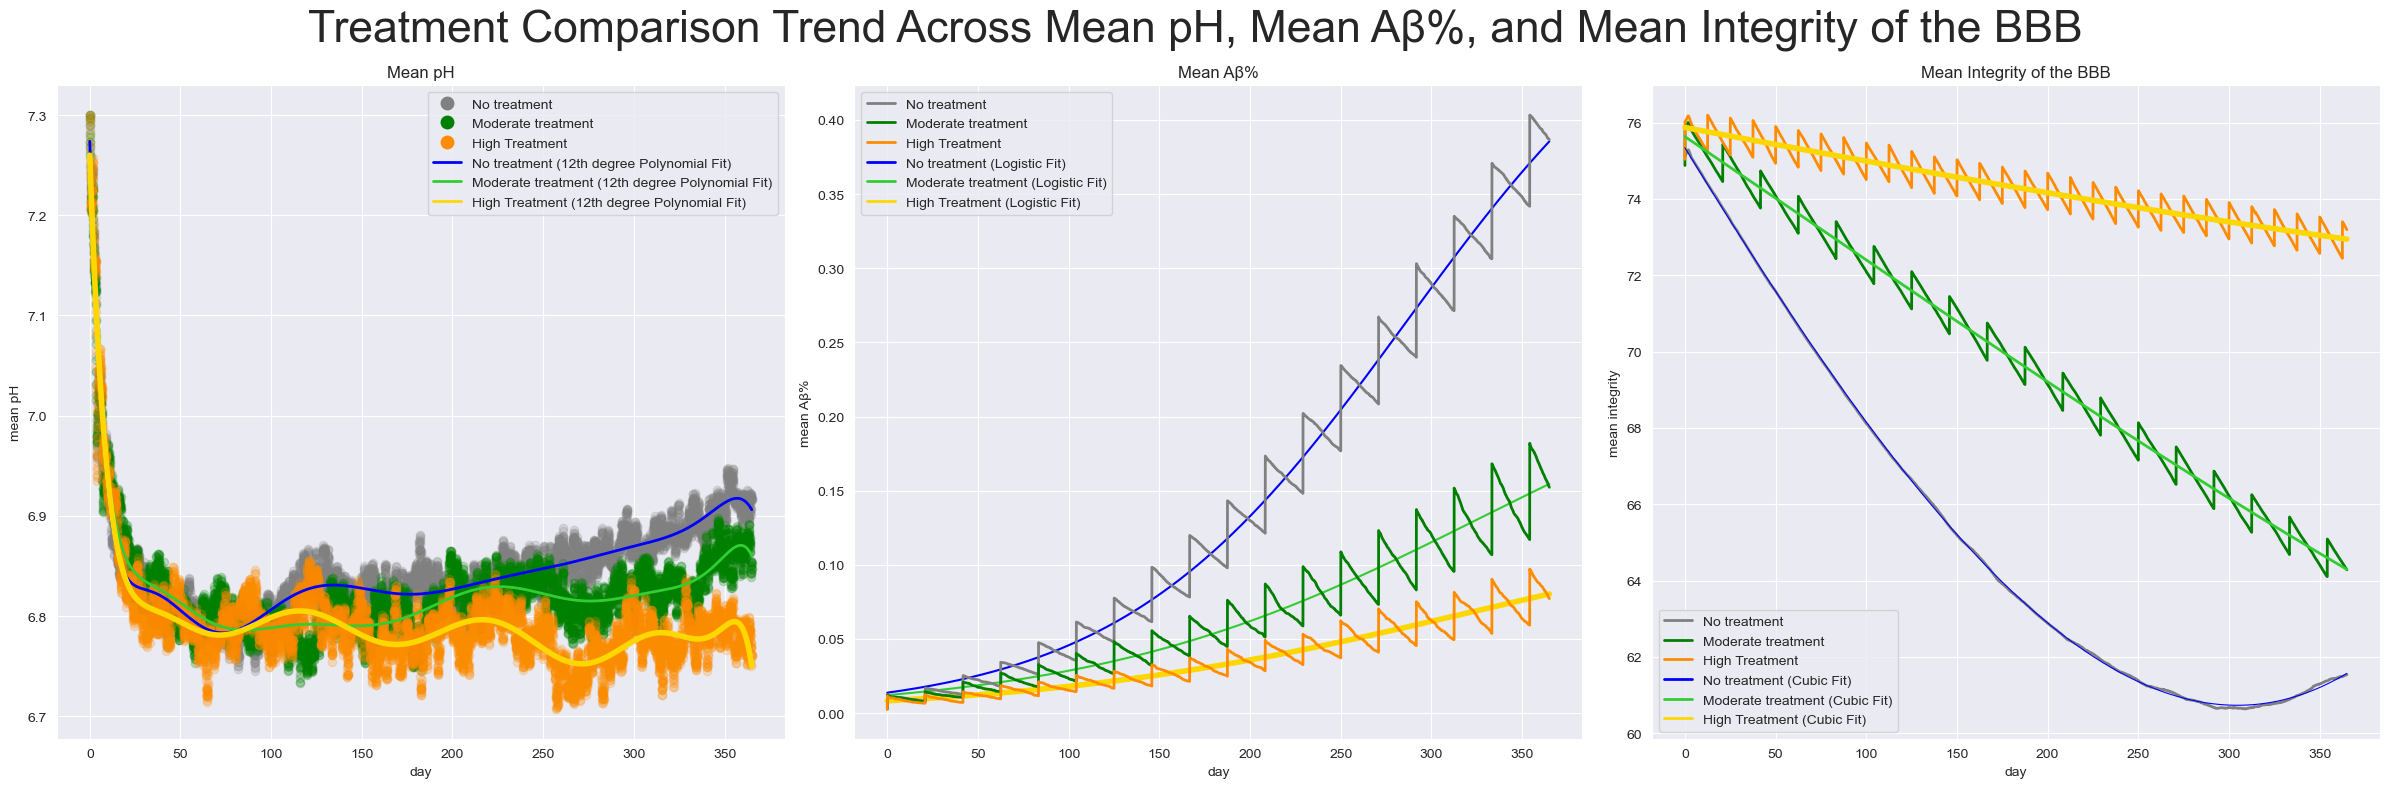

In [75]:
# Obtain the model fit for `mean_ph_none`

response_mean_ph_none = treatment_means['mean_ph_none']
    
# creating the basis functions(i.e X, X^2, X^3,...,X^ph_degree)

poly_cubic_model_mean_ph_none = MS([poly("day",degree=12)]).fit(treatment_means)
# obtain the design matrix after applying the polynomial regression model
        
design_mat_treatment_ph_none_means = poly_cubic_model_mean_ph_none.transform(treatment_means)
# fit a least squares model to the polynomial terms

ls_cubic_model_mean_ph_none = sm.OLS(response_mean_ph_none,design_mat_treatment_ph_none_means).fit()



# Obtain a design matrix from applying the given set of basis
design_mat_mean_ph_none = poly_cubic_model_mean_ph_none.transform(treatment_means)
# Design matrix of the grid
design_grid_mean_ph_none  = poly_cubic_model_mean_ph_none.transform(day_df)
# create a linear regression model to a non-linear variable with design_mat
M_mean_ph_none = sm.OLS(response_mean_ph_none, design_mat_treatment_ph_none_means).fit() 
# obtain the estimates by applying the model to the grid 
estimates_mean_ph_none = M_mean_ph_none.get_prediction(design_grid_mean_ph_none)

# ----------------------------------------------------------------------

    
# Obtain the model fit for `mean_ph_moderate`
    
response_mean_ph_moderate = treatment_means['mean_ph_moderate']

# creating the basis functions(i.e X, X^2, X^3,...,X^ph_degree)

poly_cubic_model_mean_ph_moderate = MS([poly("day", degree=12)]).fit(treatment_means)
# obtain the design matrix after applying the polynomial regression model

design_mat_treatment_ph_moderate_means = poly_cubic_model_mean_ph_moderate.transform(treatment_means)
# fit a least squares model to the polynomial terms

ls_cubic_model_mean_ph_moderate = sm.OLS(response_mean_ph_moderate, design_mat_treatment_ph_moderate_means).fit()

# Obtain a design matrix from applying the given set of basis
design_mat_mean_ph_moderate = poly_cubic_model_mean_ph_moderate.transform(treatment_means)
# Design matrix of the grid
design_grid_mean_ph_moderate = poly_cubic_model_mean_ph_moderate.transform(day_df)
# create a linear regression model to a non-linear variable with design_mat
M_mean_ph_moderate = sm.OLS(response_mean_ph_moderate, design_mat_treatment_ph_moderate_means).fit() 
# obtain the estimates by applying the model to the grid 
estimates_mean_ph_moderate = M_mean_ph_moderate.get_prediction(design_grid_mean_ph_moderate)


# ----------------------------------------------------------------------


# Obtain the model fit for `mean_ph_high`

response_mean_ph_high = treatment_means['mean_ph_high']
        
# creating the basis functions(i.e X, X^2, X^3,...,X^ph_degree)

poly_cubic_model_mean_ph_high = MS([poly("day", degree=12)]).fit(treatment_means)
# obtain the design matrix after applying the polynomial regression model

design_mat_treatment_ph_high_means = poly_cubic_model_mean_ph_high.transform(treatment_means)
# fit a least squares model to the polynomial terms

ls_cubic_model_mean_ph_high = sm.OLS(response_mean_ph_high, design_mat_treatment_ph_high_means).fit()

# Obtain a design matrix from applying the given set of basis
design_mat_mean_ph_high = poly_cubic_model_mean_ph_high.transform(treatment_means)
# Design matrix of the grid
design_grid_mean_ph_high = poly_cubic_model_mean_ph_high.transform(day_df)
# create a linear regression model to a non-linear variable with design_mat
M_mean_ph_high = sm.OLS(response_mean_ph_high, design_mat_treatment_ph_high_means).fit() 
# obtain the estimates by applying the model to the grid 
estimates_mean_ph_high = M_mean_ph_high.get_prediction(design_grid_mean_ph_high)

# ----------------------------------------------------------------------


# Obtain the model fit for `mean_integrity_none`

response_mean_integrity_none = treatment_means['mean_integrity_none']
    
# creating the basis functions(i.e X, X^2, X^integrity_degree)

poly_cubic_model_mean_integrity_none = MS([poly("day", degree=3)]).fit(treatment_means)
# obtain the design matrix after applying the polynomial regression model

design_mat_treatment_integrity_none_means = poly_cubic_model_mean_integrity_none.transform(treatment_means)
# fit a least squares model to the polynomial terms

ls_cubic_model_mean_integrity_none = sm.OLS(response_mean_integrity_none, design_mat_treatment_integrity_none_means).fit()

# Obtain a design matrix from applying the given set of basis
design_mat_mean_integrity_none = poly_cubic_model_mean_integrity_none.transform(treatment_means)
# Design matrix of the grid
design_grid_mean_integrity_none = poly_cubic_model_mean_integrity_none.transform(day_df)
# create a linear regression model to a non-linear variable with design_mat
M_mean_integrity_none = sm.OLS(response_mean_integrity_none, design_mat_treatment_integrity_none_means).fit() 
# obtain the estimates by applying the model to the grid 
estimates_mean_integrity_none = M_mean_integrity_none.get_prediction(design_grid_mean_integrity_none)

# ----------------------------------------------------------------------


# Obtain the model fit for `mean_integrity_moderate`

response_mean_integrity_moderate = treatment_means['mean_integrity_moderate']
    
# creating the basis functions(i.e X, X^2, X^integrity_degree)

poly_cubic_model_mean_integrity_moderate = MS([poly("day", degree=3)]).fit(treatment_means)
# obtain the design matrix after applying the polynomial regression model

design_mat_treatment_integrity_moderate_means = poly_cubic_model_mean_integrity_moderate.transform(treatment_means)
# fit a least squares model to the polynomial terms

ls_cubic_model_mean_integrity_moderate = sm.OLS(response_mean_integrity_moderate, design_mat_treatment_integrity_moderate_means).fit()

# Obtain a design matrix from applying the given set of basis
design_mat_mean_integrity_moderate = poly_cubic_model_mean_integrity_moderate.transform(treatment_means)
# Design matrix of the grid
design_grid_mean_integrity_moderate = poly_cubic_model_mean_integrity_moderate.transform(day_df)
# create a linear regression model to a non-linear variable with design_mat
M_mean_integrity_moderate = sm.OLS(response_mean_integrity_moderate, design_mat_treatment_integrity_moderate_means).fit() 
# obtain the estimates by applying the model to the grid 
estimates_mean_integrity_moderate = M_mean_integrity_moderate.get_prediction(design_grid_mean_integrity_moderate)


# ----------------------------------------------------------------------


# Obtain the model fit for `mean_integrity_high`

response_mean_integrity_high = treatment_means['mean_integrity_high']
    
# creating the basis functions(i.e X, X^2, X^integrity_degree)

poly_cubic_model_mean_integrity_high = MS([poly("day", degree=3)]).fit(treatment_means)
# obtain the design matrix after applying the polynomial regression model

design_mat_treatment_integrity_high_means = poly_cubic_model_mean_integrity_high.transform(treatment_means)
# fit a least squares model to the polynomial terms

ls_cubic_model_mean_integrity_high = sm.OLS(response_mean_integrity_high, design_mat_treatment_integrity_high_means).fit()

# Obtain a design matrix from applying the given set of basis
design_mat_mean_integrity_high = poly_cubic_model_mean_integrity_high.transform(treatment_means)
# Design matrix of the grid
design_grid_mean_integrity_high = poly_cubic_model_mean_integrity_high.transform(day_df)
# create a linear regression model to a non-linear variable with design_mat
M_mean_integrity_high = sm.OLS(response_mean_integrity_high, design_mat_treatment_integrity_high_means).fit() 
# obtain the estimates by applying the model to the grid 
estimates_mean_integrity_high = M_mean_integrity_high.get_prediction(design_grid_mean_integrity_high) 
              

# ----------------------------------------------------------------------

        
# Creating the plots for the treatment data
fig, ax = plt.subplots(1,3,figsize=(24,8))



# plotting the ph data

# plot the data points for `mean_ph_none`
ax[0].scatter(time_frame,response_mean_ph_none,facecolor='grey',alpha=0.2)

    # iterating here to plot the fitted values 
for val,ls in zip([estimates_mean_ph_none.predicted_mean], # obtain the predicted means from predcicited values,
    ['b']): # color and design for the lines
                      
    ax[0].plot(day_df.values,val,ls,linewidth=2)


 # plot the data points for `mean_ph_moderate`
ax[0].scatter(time_frame,response_mean_ph_moderate,facecolor='green',alpha=0.2)
        
    # iterateing here to plot the fitted values 
for val,ls in zip([estimates_mean_ph_moderate.predicted_mean], # obtain the predicted means from predcicited values,
                             # color and design for the lines
                            ['limegreen']):
                      
    ax[0].plot(day_df.values,val,ls,linewidth=2)


# plot the data points for `mean_ph_high`
ax[0].scatter(time_frame,response_mean_ph_high,facecolor='darkorange',alpha=0.2)
    # iterateing here to plot the fitted values
for val,ls in zip([estimates_mean_ph_high.predicted_mean], # obtain the predicted means from predcicited values,
                             # color and design for the lines
                            ['gold']):
                      
    ax[0].plot(day_df.values,val,ls,linewidth=4) # increase on line width for visibility

    
# creating the line symbols that will consistently appear on the legend for the pH data plots
custom_lines_ph = [
            Line2D([], [], color='none', markersize=10, marker='o',markerfacecolor='grey',markeredgecolor='none'),  # marker treatment none 
            Line2D([], [], color='none', markersize=10, marker='o',markerfacecolor='green',markeredgecolor='none'),  # marker treatment none 
            Line2D([], [], color='none', markersize=10, marker='o',markerfacecolor='darkorange',markeredgecolor='none'),  # marker treatment none 
            Line2D([], [], color='b', linewidth=2, linestyle='-'),    # line for fitted treatment none 
            Line2D([], [], color='limegreen', linewidth=2, linestyle='-'),  # line for fitted treatment moderate 
            Line2D([], [], color='gold', linewidth=2, linestyle='-')  # line for fitted treatment high
        ]
    
    


# appropriate labels
lables_ph = ["No treatment","Moderate treatment",
                    "High Treatment","No treatment (12th degree Polynomial Fit)",
                     "Moderate treatment (12th degree Polynomial Fit)",
                    "High Treatment (12th degree Polynomial Fit)"]



# assign the legend
ax[0].legend(handles = custom_lines_ph,
                     labels=lables_ph) 


# ----------------------------------------------------------------------


# plotting the plaque data
    
# fitted lines
fitted_plaque_plots =  [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[1]) for var in fitted_values[3:6]]
    
# set the relavent colors on the plaque data plots for consistency
fitted_plaque_plots[0].lines[0].set_color('b') # get the first line on the first axes(first plot, fit for the plaque_none data)
fitted_plaque_plots[1].lines[1].set_color('limegreen')
fitted_plaque_plots[2].lines[2].set_color('gold')
fitted_plaque_plots[2].lines[2].set_linewidth(4)
        

# plots the plaque data for each treatment
plaque_plots =  [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[1],linewidth=2) for var in vars_plaque]

        
    
# creating the line symbols that will consistently appear on the each legend for the plaque on and integrity data

custom_lines = [
            Line2D([], [], color='grey', linewidth=2, linestyle='-'),  # line treatment none 
            Line2D([], [], color='g', linewidth=2, linestyle='-'),    # line treatment moderate
            Line2D([], [], color='darkorange', linewidth=2, linestyle='-'),  # line treatment high 
            Line2D([], [], color='b', linewidth=2, linestyle='-'),    # line for fitted treatment none 
            Line2D([], [], color='limegreen', linewidth=2, linestyle='-'),  # line for fitted treatment moderate 
            Line2D([], [], color='gold', linewidth=2, linestyle='-')  # line for fitted treatment high
        ]


# appropriate labels
labels_plaque = [
            "No treatment",
            "Moderate treatment",
            "High Treatment",
            "No treatment (Logistic Fit)",
             "Moderate treatment (Logistic Fit)",
            "High Treatment (Logistic Fit)"
        ]
    

# assign the legend
ax[1].legend(handles = custom_lines,
                 labels=labels_plaque)


# ----------------------------------------------------------------------

# plotting the integrity data
integrity_plots = [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[2],linewidth=2) for var in vars_integrity]

# plotting the fitted values
for val, ls in zip([estimates_mean_integrity_none.predicted_mean], ['b']):
        ax[2].plot(day_df.values, val, ls, linewidth=0.8)

        
# plotting the fitted values
for val, ls in zip([estimates_mean_integrity_moderate.predicted_mean], ['limegreen']):
        ax[2].plot(day_df.values, val, ls, linewidth=2)

       
 # plotting the fitted values
for val, ls in zip([estimates_mean_integrity_high.predicted_mean], ['gold']):
        ax[2].plot(day_df.values, val, ls, linewidth=4)
        

# appropriate labels
labels_integrity = [
         "No treatment",
            "Moderate treatment",
            "High Treatment",
            "No treatment (Cubic Fit)",
             "Moderate treatment (Cubic Fit)",
            "High Treatment (Cubic Fit)"
        ]
        


# assign the legend

ax[2].legend(handles = custom_lines,
                        labels=labels_integrity)

# ----------------------------------------------------------------------


# main title
plt.suptitle("Treatment Comparison Trend Across Mean pH, Mean Aβ%, and Mean Integrity of the BBB",size=32)


# setting appropriate titles for the subplots
ax[0].set_title("Mean pH")
ax[1].set_title("Mean Aβ%") 
ax[2].set_title("Mean Integrity of the BBB") 

# setting appropriate y labels
ax[0].set_ylabel("mean pH")
ax[1].set_ylabel("mean Aβ%") 
ax[2].set_ylabel("mean integrity") 




# setting appropriate x labels
[ax[i].set_xlabel("day") for i in np.arange(3)]


plt.tight_layout()

## Graphs of Only the Best Fit Lines
 - Mean AB%
 - Mean integrity of the BBB

In [77]:
# custom line objects for legend that represent the fitted lines
custom_lines_fitted = [
            Line2D([], [], color='b', linewidth=2, linestyle='-'),    # line for fitted treatment none 
            Line2D([], [], color='limegreen', linewidth=2, linestyle='-'),  # line for fitted treatment moderate 
            Line2D([], [], color='gold', linewidth=2, linestyle='-')  # line for fitted treatment high
        ]

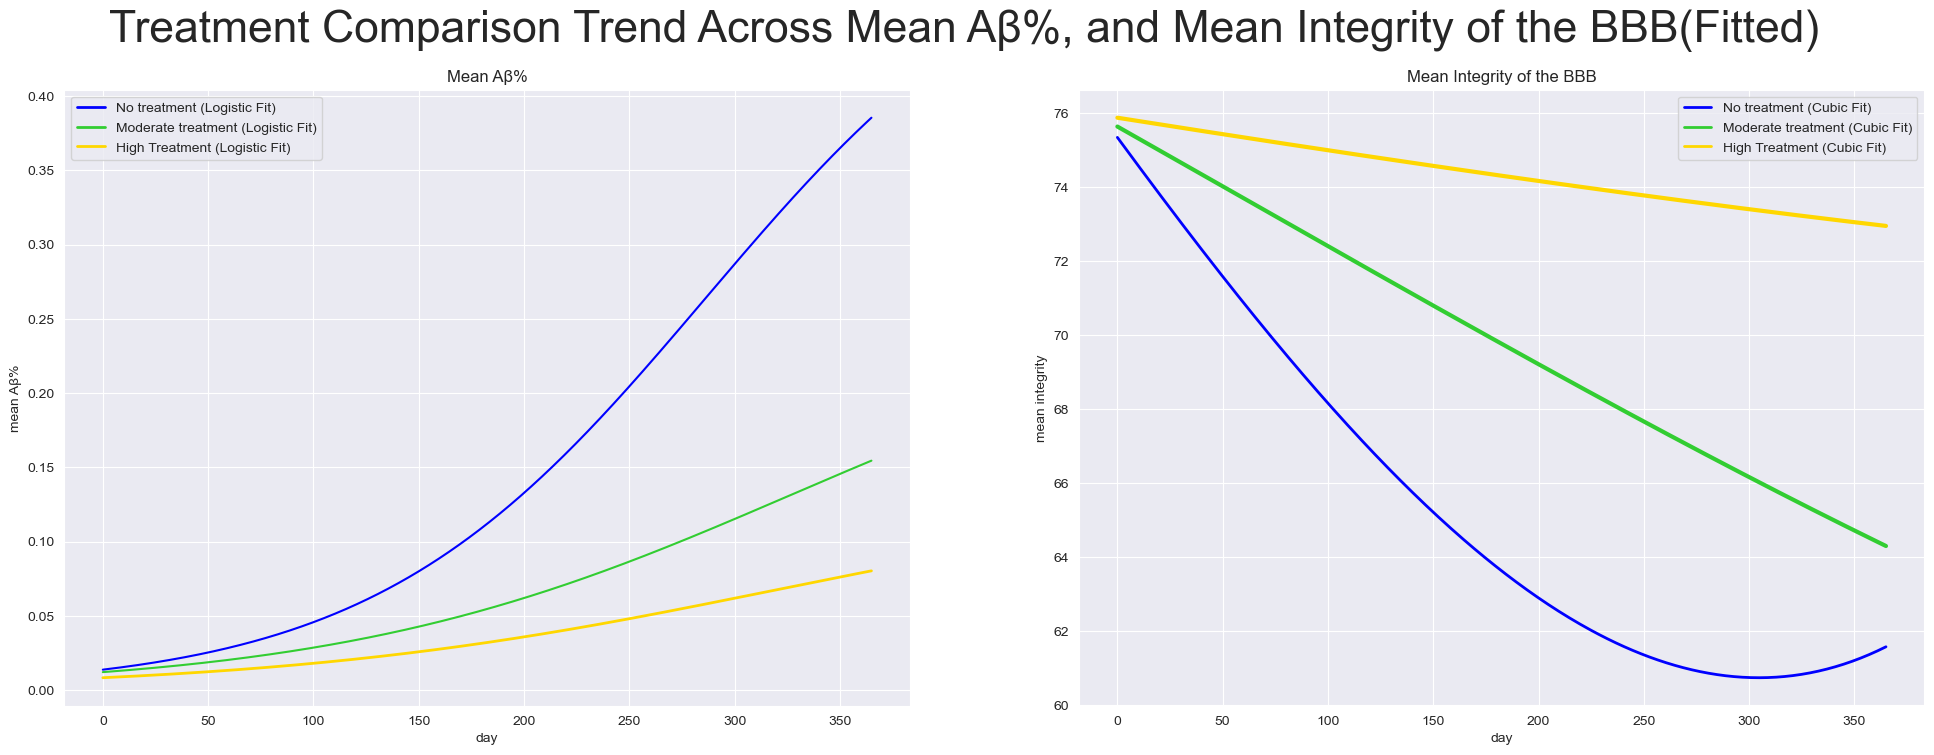

In [78]:
# establish subplots 

fig, ax = plt.subplots(1,2,figsize=(24,8))

# plots of the fitted lines

fitted_plaque_plots =  [sns.lineplot(data= treatment_means,x='day',y=var,ax=ax[0]) for var in fitted_values[3:6]]


# set the relavent colors on the plaque data plots for consistency
fitted_plaque_plots[0].lines[0].set_color('b') # get the first line on the first axes(first plot, fit for the plaque_none data)
fitted_plaque_plots[1].lines[1].set_color('limegreen')
fitted_plaque_plots[2].lines[2].set_color('gold')
fitted_plaque_plots[2].lines[2].set_linewidth(2)
        

# appropriate labels
labels_plaque = [
            "No treatment (Logistic Fit)",
             "Moderate treatment (Logistic Fit)",
            "High Treatment (Logistic Fit)"
        ]
    

# assign the legend
ax[0].legend(handles = custom_lines_fitted,
                 labels=labels_plaque)



# plotting of the fitted integrity values

# plotting the fitted values
for val, ls in zip([estimates_mean_integrity_none.predicted_mean], ['b']):
        ax[1].plot(day_df.values, val, ls, linewidth=2)

        
        
        
# plotting the fitted values
for val, ls in zip([estimates_mean_integrity_moderate.predicted_mean], ['limegreen']):
        ax[1].plot(day_df.values, val, ls, linewidth=3)

        
# plotting the fitted values
for val, ls in zip([estimates_mean_integrity_high.predicted_mean], ['gold']):
        ax[1].plot(day_df.values, val, ls, linewidth=3)
        

# appropriate labels
labels_integrity = [
            "No treatment (Cubic Fit)",
             "Moderate treatment (Cubic Fit)",
            "High Treatment (Cubic Fit)"
        ]
        


# assign the legend

ax[1].legend(handles = custom_lines_fitted,
                        labels=labels_integrity)





# main title
plt.suptitle("Treatment Comparison Trend Across Mean Aβ%, and Mean Integrity of the BBB(Fitted)",size=32)


# setting appropriate titles for the subplots

ax[0].set_title("Mean Aβ%") 
ax[1].set_title("Mean Integrity of the BBB") 

# setting appropriate y labels

ax[0].set_ylabel("mean Aβ%") 
ax[1].set_ylabel("mean integrity") 




# setting appropriate x labels
[ax[i].set_xlabel("day") for i in np.arange(2)]

plt.show()